In [29]:
import os

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [32]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="Gemma2-9b-It")

In [39]:
from typing_extensions import TypedDict
from typing import Optional
from pydantic import BaseModel 


class ReviewSummary(BaseModel):
    language : str
    lint_analysis: str
    logic_analysis: str
    best_practices: str
    security_performance: str
    test_report: str
    overall_comment: str

class CodeReviewer(TypedDict):
    
    code : str
    language : str

    lint_checker : str  # process of using a tool, called a linter,
    # to analyze source code for errors, style issues, and potential bugs.

    logic_analysis : str
    best_practices : str
    security_analysis : str
    test_cases: str
    test_results: str
    test_analysis: str

    review_summary : ReviewSummary


In [40]:
def detect_language(state: CodeReviewer):
    """
    Detect the language of the code
    """
    prompt = f"""What programming language is this code?
            {state['code']}
             Respond with just the language name."""
    response = llm.invoke( prompt )
    return { "language" : response.content }


def lint_checker(state: CodeReviewer):
    prompt = f"Perform linting and identify style issues in the following {state['language']} code:\n\n{state['code']}"
    response = llm.invoke( prompt )
    return { "lint_checker" : response.content }


def logic_analysis(state: CodeReviewer) :

    prompt = f"Analyze the logic of the following {state['language']} code and point out any logical errors or improvements:\n\n{state['code']}"
    response = llm.invoke( prompt )
    
    return {"logic_analysis" : response.content}

def best_practices(state: CodeReviewer) :
   
    prompt = f"Check whether the following {state['language']} code follows best practices and recommend any improvements:\n\n{state['code']}"
    response = llm.invoke( prompt )
    return { "best_practices" : response.content }

def security_check(state: CodeReviewer):
   
    prompt = f"Review this {state['language']} code for any security or performance issues:\n\n{state['code']}"
    response = llm.invoke( prompt )
    return { "security_analysis" : response.content }


def generate_test_cases(state: CodeReviewer) :
   
    prompt = f"Generate test cases for this {state['language']} code. Include normal and edge cases. Return only code:\n\n{state['code']}"
    response = llm.invoke( prompt )
    return { "test_cases" : response.content }

def run_test_cases(state: CodeReviewer) :
    prompt = f"""
You're a code reviewer. Simulate running the following test cases for this {state['language']} code.
Mark each test as pass/fail and explain failures if any.

Code:\n{state['code']}

Test Cases:\n{state['test_cases']}
"""
    response = llm.invoke( prompt )
    return { "test_results" : response.content }

def analyze_failed_tests(state: CodeReviewer) :

    prompt = f"""
Analyze the failed test cases and explain what might be causing the issues.
Also suggest how to fix the code to make them pass.
Lets keep the report generalized and formal

Code:\n{state['code']}
Test Results:\n{state['test_results']}
"""
    response = llm.invoke( prompt )
    return { "test_analysis" : response.content }


In [54]:
def review_summary(state: CodeReviewer):
    """
    Use the LLM to generate a structured review summary aggregating all aspects.
    """
    prompt = f"""
You're a senior software engineer and code reviewer. Based on the following analyses of a {state['language']} code snippet, write a structured final review.

Use clear headers and concise feedback for each section:
- Linting & Style
- Logic & Correctness
- Best Practices
- Security & Performance
- Test Case Evaluation
- Final Verdict

=== Linting Analysis ===
{state['lint_checker']}

=== Logic Analysis ===
{state['logic_analysis']}

=== Best Practices ===
{state['best_practices']}

=== Security & Performance ===
{state['security_analysis']}

=== Test Analysis ===
{state.get('test_analysis', 'No test analysis available')}

Return the summary in markdown format.
"""
    response = llm.invoke(prompt)

    summary = ReviewSummary(
        language=state["language"],
        lint_analysis=state["lint_checker"],
        logic_analysis=state["logic_analysis"],
        best_practices=state["best_practices"],
        security_performance=state["security_analysis"],
        test_report=state.get('test_analysis', 'No test analysis available'),
        overall_comment=response.content  # LLM will generate this section
    )

    return {"review_summary": summary}


In [55]:
from langgraph.graph import START , END , StateGraph

graph_builder = StateGraph(CodeReviewer)

graph_builder.add_node("recognize_language" , detect_language)
graph_builder.add_node("lint_analyzer" , lint_checker)
graph_builder.add_node("logic_analyzer" , logic_analysis)
graph_builder.add_node("best_practices_to_follow",best_practices)
graph_builder.add_node("security_report",security_check)

graph_builder.add_node("TestCase_Generator",generate_test_cases)
graph_builder.add_node("Running_TestCases",run_test_cases)
graph_builder.add_node("TestCase_Report",analyze_failed_tests)

graph_builder.add_node("Final_Review" , review_summary)

graph_builder.add_edge(START ,"recognize_language")

graph_builder.add_edge("recognize_language" , "lint_analyzer")
graph_builder.add_edge("recognize_language" , "logic_analyzer")
graph_builder.add_edge("recognize_language" , "best_practices_to_follow")
graph_builder.add_edge("recognize_language" , "security_report")

graph_builder.add_edge("recognize_language" , "TestCase_Generator")
graph_builder.add_edge("TestCase_Generator" , "Running_TestCases")
graph_builder.add_edge("Running_TestCases" , "TestCase_Report")

graph_builder.add_edge("lint_analyzer" , "Final_Review")
graph_builder.add_edge("logic_analyzer" , "Final_Review")
graph_builder.add_edge( "TestCase_Report" , "Final_Review")
graph_builder.add_edge("best_practices_to_follow" , "Final_Review")
graph_builder.add_edge("security_report" , "Final_Review")


graph_builder.add_edge("Final_Review" , END)


graph = graph_builder.compile()

In [56]:
# from langgraph.graph import START , END , StateGraph

# graph_builder = StateGraph(CodeReviewer)


# graph_builder.add_node("recognize_language" , detect_language)
# graph_builder.add_node("TestCase_Generator",generate_test_cases)
# graph_builder.add_node("Running_TestCases",run_test_cases)
# graph_builder.add_node("TestCases_Report",analyze_failed_tests)

# graph_builder.add_edge(START ,"recognize_language")

# graph_builder.add_edge("recognize_language" , "TestCase_Generator")
# graph_builder.add_edge("TestCase_Generator" , "Running_TestCases")
# graph_builder.add_edge("Running_TestCases" , "TestCases_Report")

# graph_builder.add_edge( "TestCases_Report" , END )

# graph = graph_builder.compile()

In [57]:
graph.invoke( {"code" : """

def add(a , b) :
    return a + b

"""} )

{'code': '\n\ndef add(a , b) :\n    return a + b\n\n',
 'language': 'Python \n',
 'lint_checker': 'The code you\'ve provided has a minor style issue according to PEP 8, the standard style guide for Python.\n\n**Issue:**\n\n* **Function definition spacing:**  PEP 8 recommends using a single space after the function name and  before the opening parenthesis in function definitions.\n\n**Corrected Code:**\n\n```python\ndef add(a, b):\n    return a + b \n```\n\n**Explanation:**\n\n* The original code has no spaces after "add" and before the opening parenthesis.\n* The corrected code adds a single space after "add" and before the opening parenthesis, adhering to PEP 8 guidelines.\n\n**Other Considerations:**\n\nWhile the spacing issue is the most noticeable, here are some additional style tips:\n\n* **Naming conventions:** Function names should generally be in lowercase with underscores (e.g., `add_numbers`).\n* **Docstrings:** Adding a docstring to your function, explaining what it does, is

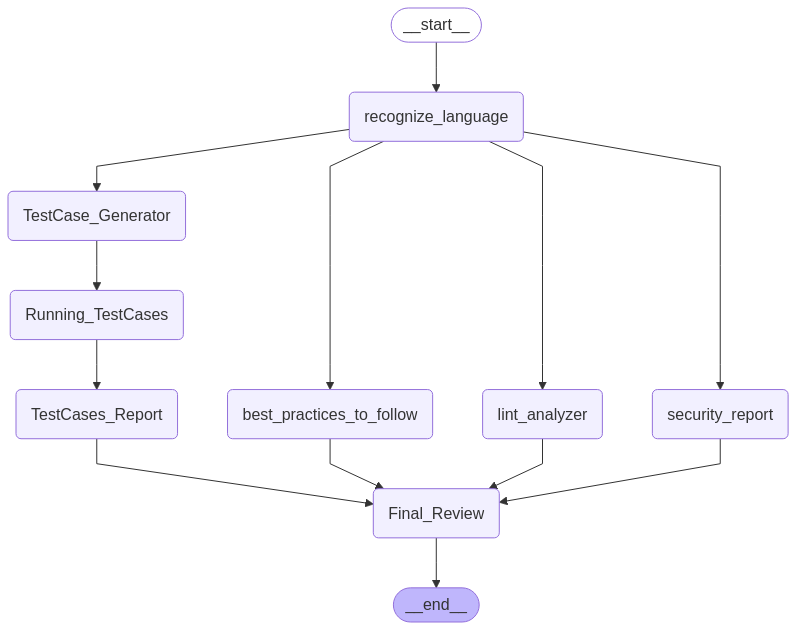

In [51]:
from IPython.display import Image , display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [ ]:
#